# Spotify Final Project
### Austin Rochon, Emily Xie, and Mark Lock
### Milestone 4
*Contents*
1. Baseline model - KNN using K-means cluster labels
2. Recommendation procedure - inverse distance monte carlo playlist selection
3. Simplest model - KNN for each playlist using musical features
4. Structural model - Logistic regression for each playlist using musical features

### 1. Baseline model - KNN using K-means cluster labels

In [270]:
# Import requisite packages
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

#### Run this cell to load google cloud bigquery:

In [5]:
# Set up credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="PATH"

In [6]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [7]:
%%bigquery playlist_data
WITH cte AS (
  SELECT *, 
    ROW_NUMBER() OVER(PARTITION BY track_uri ORDER BY unique_pid) AS track_row
  FROM playlist_songs.playlist_tracks_joined_rand
  LIMIT 500000
)
SELECT * 
FROM cte
WHERE track_row = 1
LIMIT 100000

#### Data cleaning

Create dataframe with song-playlist mappings (for later analysis)

In [8]:
# Copy df
playlist_mapping = playlist_data.copy()
playlist_mapping = playlist_mapping.set_index("trackid")
playlist_mapping = playlist_mapping["unique_pid"]

# Create mapping df containing trackid and list of playlists it's associated with
# https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby
playlist_mapping = playlist_mapping.groupby("trackid").apply(list).reset_index(name="playlists")
playlist_mapping.head()


,trackid,playlists
0,spotify:track:000T9PNzxi3xNEucKererm,[303678]
1,spotify:track:000xQL6tZNLJzIrtIgxqSl,[17343]
2,spotify:track:000xYdQfIZ4pDmBGzQalKU,[686817]
3,spotify:track:001BVhvaZTf2icV88rU3DA,[676618]
4,spotify:track:002HVvfZx6AKPzJEeimuu5,[423684]


First fetch only numeric data

In [9]:
# Pull in only audio features 
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
playlist_numeric = playlist_data.select_dtypes(include=numerics)
playlist_numeric["trackid"] = playlist_data["trackid"]
playlist_numeric = playlist_numeric.set_index("trackid")
playlist_numeric = playlist_numeric.drop(["index","pid", "pos", "unique_pid", "track_row", "random"], axis=1)
playlist_numeric.head()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:001BVhvaZTf2icV88rU3DA,0.775,0.355,6.0,-11.755,0.0,0.1580,0.061000,0.013700,0.166,0.356,87.997,205256.0,4.0
spotify:track:002HVvfZx6AKPzJEeimuu5,0.232,0.485,7.0,-13.939,0.0,0.0556,0.779000,0.934000,0.116,0.239,73.347,154573.0,4.0
spotify:track:004skCQeDn1iLntSom0rRr,0.605,0.846,9.0,-4.581,1.0,0.0778,0.000738,0.000001,0.053,0.764,132.997,177773.0,4.0
spotify:track:00CQsyWt5NGD7kaKBvG33Y,0.688,0.589,9.0,-7.276,1.0,0.1530,0.257000,0.005710,0.102,0.857,125.937,147547.0,4.0
spotify:track:00CujlY4ya5p2FNDu9BCZP,0.377,0.745,8.0,-5.059,0.0,0.0696,0.021900,0.000052,0.185,0.344,76.526,252416.0,4.0


## Modeling

#### K-means for labeling
The first thing we'll want to do is find similarities between "groups" of songs in our data set. To do so, we'll first need to construct groups, using their audio properties as features to group them by. Before we begin, we need to normalize our data.

In [10]:
def normalize(df, scalar, features):
    # Split df into features and non-features
    non_feature_df = df[df.columns.difference(features)]
    feature_df = df[features]
    
    # Scale the features
    np_transform = scalar.transform(feature_df)
    df_transform = pd.DataFrame(np_transform, columns=features)

    # Merge back the features and non-features
    non_feature_df.reset_index(drop=True, inplace=True)
    df_transform.reset_index(drop=True, inplace=True)
    df_transform = pd.concat([non_feature_df, df_transform], axis = 1)
    
    return df_transform

In [11]:
# Fit MinMaxScalar and select features we will be using (all columns from playlist_numeric)
scalar = MinMaxScaler().fit(playlist_numeric)
features = playlist_numeric.columns

# Normalize data
playlist_norm = normalize(playlist_numeric, scalar, features)
playlist_norm["trackid"] = playlist_numeric.index
playlist_norm = playlist_norm.set_index("trackid")

# Drop NAs
display(playlist_norm.shape)
playlist_norm = playlist_norm.dropna(how="any")
display(playlist_norm.shape)

display(playlist_numeric.head())
display(playlist_norm.head())

(100000, 13)

(99710, 13)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:001BVhvaZTf2icV88rU3DA,0.775,0.355,6.0,-11.755,0.0,0.1580,0.061000,0.013700,0.166,0.356,87.997,205256.0,4.0
spotify:track:002HVvfZx6AKPzJEeimuu5,0.232,0.485,7.0,-13.939,0.0,0.0556,0.779000,0.934000,0.116,0.239,73.347,154573.0,4.0
spotify:track:004skCQeDn1iLntSom0rRr,0.605,0.846,9.0,-4.581,1.0,0.0778,0.000738,0.000001,0.053,0.764,132.997,177773.0,4.0
spotify:track:00CQsyWt5NGD7kaKBvG33Y,0.688,0.589,9.0,-7.276,1.0,0.1530,0.257000,0.005710,0.102,0.857,125.937,147547.0,4.0
spotify:track:00CujlY4ya5p2FNDu9BCZP,0.377,0.745,8.0,-5.059,0.0,0.0696,0.021900,0.000052,0.185,0.344,76.526,252416.0,4.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:001BVhvaZTf2icV88rU3DA,0.784413,0.355,0.545455,0.768649,0.0,0.163900,0.061245,0.013700,0.166,0.356,0.354741,0.043233,0.8
spotify:track:002HVvfZx6AKPzJEeimuu5,0.234818,0.485,0.636364,0.733853,0.0,0.057676,0.782129,0.934000,0.116,0.239,0.295682,0.032397,0.8
spotify:track:004skCQeDn1iLntSom0rRr,0.612348,0.846,0.818182,0.882946,1.0,0.080705,0.000741,0.000001,0.053,0.764,0.536149,0.037357,0.8
spotify:track:00CQsyWt5NGD7kaKBvG33Y,0.696356,0.589,0.818182,0.840009,1.0,0.158714,0.258032,0.005710,0.102,0.857,0.507688,0.030894,0.8
spotify:track:00CujlY4ya5p2FNDu9BCZP,0.381579,0.745,0.727273,0.875331,0.0,0.072199,0.021988,0.000052,0.185,0.344,0.308498,0.053317,0.8


#### Run k-means with chosen number of clusters (12)
The code below runs k-means clustering, assigns cluster labels, and outputs 1) our raw data with cluster assignments, and 2) mean data for each cluster

In [12]:
def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers


def build_kmeans_output(data, col_name):
    '''Builds out final dataset'''
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    
    
    
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("trackid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['trackid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'trackid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10:"K", 11:"L"}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data    

In [13]:
k = 12
playlist_norm["trackid"] = playlist_norm.index
playlist_means, playlist_clusters = run_kmeans(playlist_norm, k)
playlist_means

,n,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha
cluster,,,,,,,,,,,,,,,,
0,9921,0.673501,0.733242,0.124923,0.850971,1.0,0.103688,0.173493,0.017766,0.201296,0.736067,0.495171,0.046717,0.792803,0,A
1,10271,0.532921,0.708741,0.132376,0.853756,1.0,0.092156,0.089337,0.023058,0.227768,0.326965,0.508174,0.052299,0.788200,1,B
2,12305,0.642654,0.719278,0.830764,0.850848,0.0,0.122460,0.144707,0.022993,0.210004,0.551692,0.492036,0.050323,0.794067,2,C
3,11379,0.521121,0.721368,0.720098,0.854944,1.0,0.088842,0.086353,0.023970,0.229279,0.347172,0.507880,0.051696,0.788452,3,D
4,5398,0.459254,0.300409,0.504126,0.731035,0.0,0.070208,0.800265,0.298768,0.168817,0.289242,0.449339,0.051365,0.756206,4,E
5,3468,0.593388,0.700279,0.565272,0.821950,0.0,0.068527,0.126662,0.757900,0.196823,0.400799,0.502191,0.059779,0.788120,5,F
6,4268,0.568529,0.715319,0.430476,0.824461,1.0,0.067967,0.108123,0.772308,0.193737,0.413500,0.503547,0.058342,0.788285,6,G
7,7582,0.526284,0.369839,0.730654,0.780992,1.0,0.075838,0.712843,0.024284,0.192324,0.394949,0.463130,0.047868,0.761435,7,H
8,7457,0.504635,0.341875,0.179124,0.774958,1.0,0.070596,0.738935,0.024250,0.185118,0.349706,0.462141,0.048914,0.761352,8,I


#### Visualize attributes across clusters

In [14]:
def plot_bar_by_cluster(df, cols):
    sns.set(style="whitegrid")

    # Draw a nested barplot 
    chart = sns.catplot(x=cols[0], y=cols[1], data=df[cols],
                    height=6, kind="bar", palette="Blues_r")
    chart.despine(left=True)
    chart.set_ylabels(cols[1])
    chart.set_xlabels(cols[0])
    if cols[1] == "n":
        plt.title(f"""{cols[1]} by cluster""", pad=0); 
    else:
        plt.title(f"""Mean {cols[1]} by cluster""", pad=0); 
        
    plt.savefig(f"../out/{cols[1]}_cluster_comparison.svg", dpi=1200)

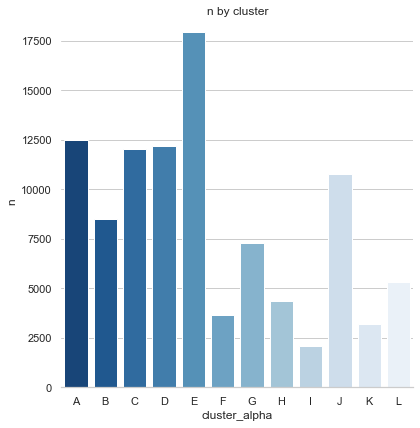

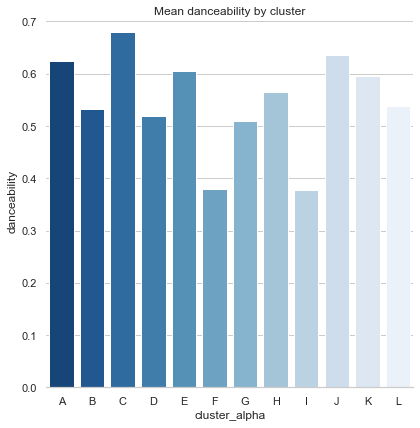

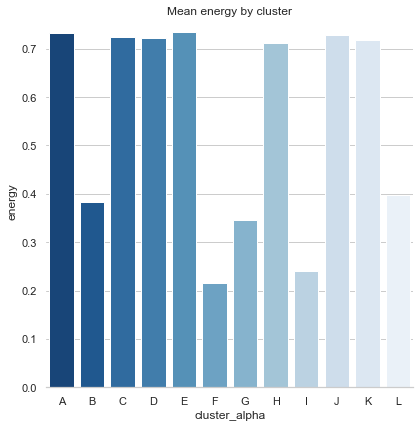

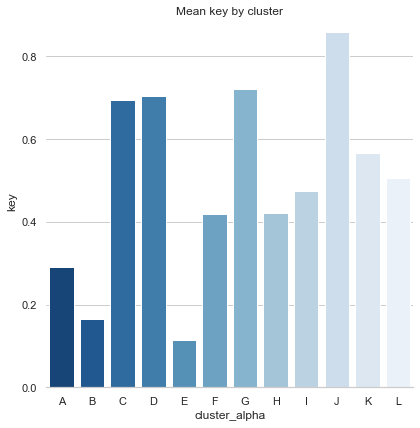

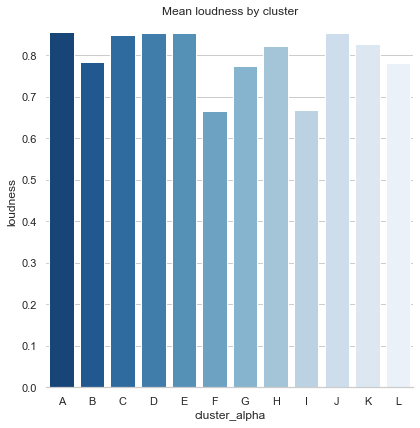

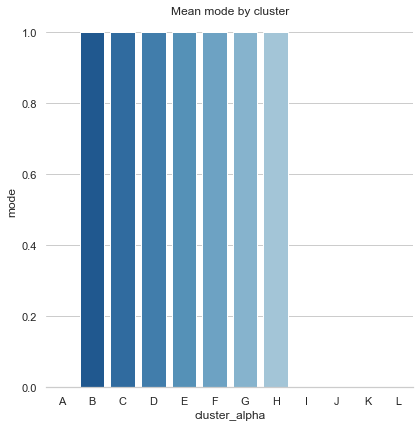

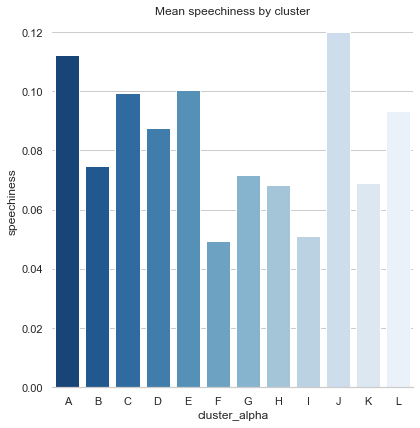

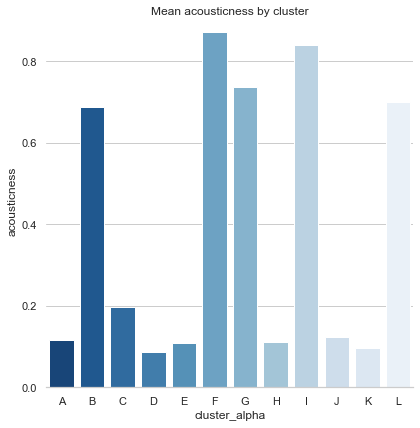

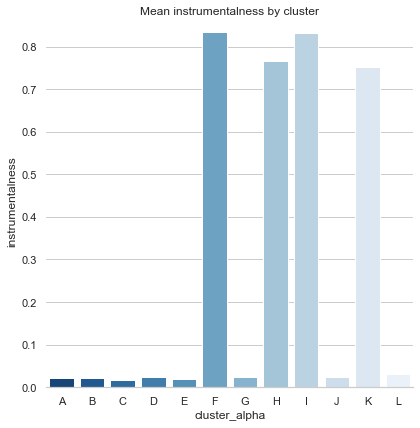

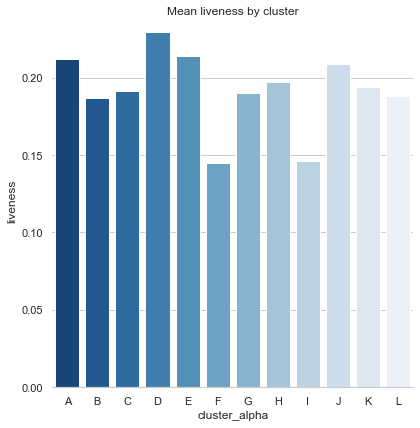

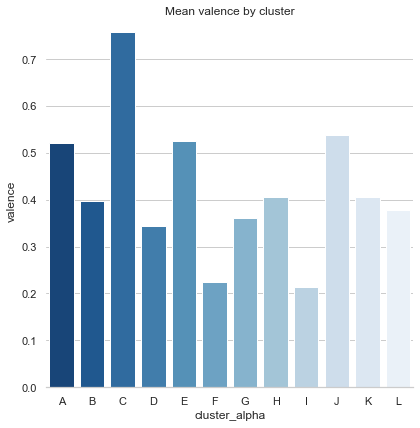

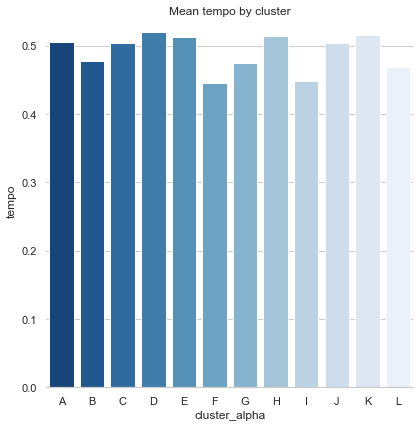

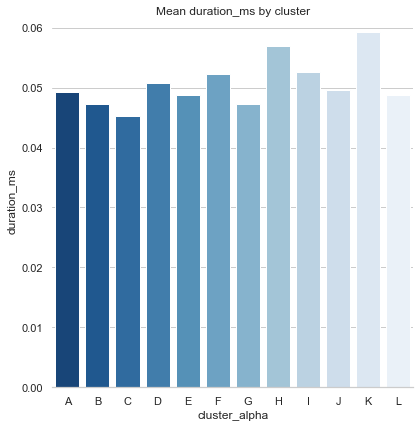

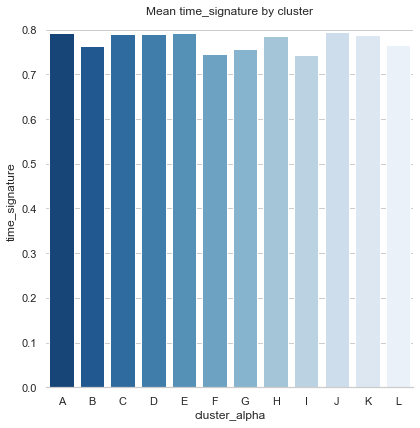

In [105]:
features = ['n','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'time_signature']

for feature in features:
    cols = ["cluster_alpha"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

#### K-Nearest Neighbors
Now that we have labels for our tracks (cluster number), we can build a recommender engine. Let's use K-Nearest neighbors to fit future songs to a given cluster. First, we need to split our data into train and test.

In [15]:
playlist_clusters = playlist_clusters.drop(["trackid", "cluster_alpha"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(playlist_clusters.loc[:, playlist_clusters.columns != 'cluster'], 
                                                    playlist_clusters.cluster, test_size=0.2, 
                                                    random_state = 666, 
                                                    stratify = playlist_clusters.cluster)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79768, 13), (19942, 13), (79768,), (19942,))

Next we will fit our kNN model to our chosen k (100)

In [16]:
neighbors = 100
knn_chosen = KNeighborsClassifier(n_neighbors=neighbors).fit(X_train, y_train)
knn_chosen_predictions_train = knn_chosen.predict(X_train)
knn_chosen_predictions_test = knn_chosen.predict(X_test)

#### Make Predictions With K-Nearest Neighbors
Now that we have a model, selected using cross-validation, we can predict class labels. Can we also get the most similar song? The below returns a list of the *n* closest songs in terms of feature vector distance

In [17]:
def generate_nearest_songs(trackid, features):
    
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
    
    # Generate n closest neighbors
    feature_vector = features.loc[trackid].drop("cluster").to_numpy().reshape(1,-1)
    kneighbors = knn_chosen.kneighbors(feature_vector)
    kneighbors_indices = kneighbors[1].reshape(-1)
    kneighbors_distances = kneighbors[0].reshape(-1)
    
    # Predict cluster
    predicted_cluster = mapping[knn_chosen.predict(feature_vector)[0]]

    # Save distances to df
    distances = pd.DataFrame({"trackid": X_train.iloc[kneighbors_indices].index, "distance": kneighbors_distances})

    # Get their playlist data
    p_df = playlist_data.set_index("trackid").loc[X_train.iloc[kneighbors_indices].index]\
        [["artist_name", "track_name"]]

    # Join distances and track data
    return predicted_cluster, p_df.merge(distances, how="inner", on="trackid")


def plot_nearest_neighbors(neighbors_df, artist_track):
    plot_df = neighbors_df[["artist_track", "distance"]]
    # truncation: https://stackoverflow.com/questions/22792740/truncating-column-width-in-pandas
    plot_df["artist_track"] = plot_df["artist_track"].str[:50]
    fig, ax = plt.subplots()
    ax = sns.barplot(x='distance', y='artist_track', data=plot_df, palette="Blues_d")
    ax.set_xlabel('distance')
    plt.title(artist_track)
    
    filename = artist_track.replace(" ", "").replace(":", "_")
    plt.tight_layout()
    plt.savefig(f"../out/{filename}_nearestneighbors.svg", quality=95, dpi=1200)
    

In [ ]:
clusters = []

# Wolfgang Amadeus Mozart, Piano Concerto No.21 in C Major,: "spotify:track:3aX8Xg1XxtEplBZDORWmyv"
cluster, neighbors = generate_nearest_songs("spotify:track:3aX8Xg1XxtEplBZDORWmyv", playlist_clusters)
artist_track = "Mozart: Piano Concerto No.21 in C Major"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Kendrick Lamar, alright: "spotify:track:3iVcZ5G6tvkXZkZKlMpIUs"
cluster, neighbors = generate_nearest_songs("spotify:track:0ECs7wpW9157Tk5yBUGbE0", playlist_clusters)
artist_track = "Kendrick Lamar: alright"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Slayer, Raining Blood: "spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn"
cluster, neighbors = generate_nearest_songs("spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn", playlist_clusters)
artist_track = "Slayer: Raining Blood"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

pd.DataFrame(clusters)

#### Code for examples

Fetch trackIDs for a given artist / track

In [19]:
tester = X_train.merge(playlist_data.set_index("trackid"), how="inner", on="trackid")
# tester[tester["artist_name"] == "Lady Gaga"][["artist_name", "track_name"]]
tester[tester["track_name"] == "Bad Romance"][["artist_name", "track_name"]]


,artist_name,track_name
trackid,,
spotify:track:5xrHvVmSF3ui0EKI8FArv3,Scott Bradlee's Postmodern Jukebox,Bad Romance
spotify:track:0n3sHHfdOq6Awix3JPe3xl,Halestorm,Bad Romance
spotify:track:3vYhrG4O1NqVBSc7oXXpQH,Lissie,Bad Romance
spotify:track:5P5cGNzqh6A353N3ShDK6Y,Lady Gaga,Bad Romance


For a given song, fetch all songs within same cluster, along with their playlists and features

In [403]:
# Lady Gaga: Bad Romance
# spotify:track:5P5cGNzqh6A353N3ShDK6Y
gaga_cluster, gaga_neighbors = generate_nearest_songs("spotify:track:5P5cGNzqh6A353N3ShDK6Y", playlist_clusters.drop("cluster_alpha", axis=1))

In [404]:
# Add cluster_alpha back
mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
playlist_clusters["cluster_alpha"] = playlist_clusters["cluster"]
playlist_clusters = playlist_clusters.replace({'cluster_alpha':mapping})
playlist_clusters.head()

# Grab all associated with gaga_cluster
playlist_gaga = playlist_clusters[playlist_clusters["cluster_alpha"] == gaga_cluster]

In [405]:
# Join to playlist data
playlist_gaga = playlist_gaga.merge(playlist_mapping, how="inner", on="trackid")

# Join to track data
playlist_gaga = playlist_gaga.merge(playlist_data[["artist_name", "track_name", "trackid"]], 
                                    how="inner", on="trackid")

# playlist_gaga.to_csv("../out/gaga_cluster.csv")
playlist_gaga.head()


# # playlist_data.merge(playlist_mapping, how="inner", on="trackid")
# playlist_gaga.merge(playlist_data, how="inner", on="trackid")

,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha,playlists,artist_name,track_name
0,spotify:track:00OVN9m036NqWcABlCXFpE,0.883603,0.520,0.181818,0.838448,1.0,0.134855,0.051104,0.010100,0.0901,0.582,0.397239,0.056358,0.8,0,A,[305773],Vanessa Williams,Happiness
1,spotify:track:01HCxML9FEN3NEsVfSiCa0,0.703441,0.912,0.181818,0.914524,1.0,0.354772,0.047490,0.000000,0.6060,0.583,0.343070,0.037967,0.8,0,A,[194953],G-Unit,Salute U
2,spotify:track:01MtUZOoNYzkIU6FeQGDdR,0.783401,0.726,0.090909,0.857980,1.0,0.127593,0.180723,0.000001,0.3190,0.743,0.411199,0.054083,0.8,0,A,[229939],Natasha Bedingfield,Drop Me In The Middle
3,spotify:track:01NRpu9CeEx4DqiDjG20PA,0.619433,0.649,0.181818,0.842797,1.0,0.032365,0.552209,0.000862,0.0858,0.613,0.395021,0.050816,0.8,0,A,[548349],Greensky Bluegrass,Miss September
4,spotify:track:01YSGdA81SstXR0QAwKQxF,0.617409,0.932,0.000000,0.900647,1.0,0.218880,0.202811,0.000000,0.1960,0.862,0.436850,0.202182,0.8,0,A,[478734],Grand Maître Franco,Lettre à M. le DG


### 2. Recommendation procedure - inverse distance monte carlo playlist selection

Using Lady Gaga's Bad Romance as an example, let's examine how we would apply Monte-Carlo to playlist selection, first naively, then weighted by inverse distance.

In [406]:
def select_top_n_playlists_naive(df, n=1000):
    # Instantiate empty dict with playlist counts
    playlist_counts = {playlist[0]: 0 for playlist in df["playlists"]}
    
    # For each iteration in our specified n, count the randomly selected playlist
    for i in range(n):
        indices = np.arange(df.shape[0])
        ind = np.random.choice(indices)
        playlist_counts[df.iloc[ind]["playlists"][0]] += 1
        
    # Sort by count
    # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    playlist_counts = {str(k): v for k, v in sorted(playlist_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

    return playlist_counts

In [407]:
def plot_top_n_playlists(playlist_dict, sim_type="Naive"):
    # Build dataframe and sort by count
    df =  pd.DataFrame({"playlist": list(playlist_dict.keys()),
                        "count": list(playlist_dict.values())})
    df = df.sort_values("count", ascending=False)
    
    ax = sns.barplot(x="count", 
                 y="playlist",
                 data=df,
                 palette="Blues_r", 
                 orient="h",
                 order=df["playlist"]).set_title(f"Top Playlists Song Assigned To: {sim_type} Monte Carlo")
    plt.savefig(f"../out/top10_playlists_montecarlo_{sim_type}.svg", dpi=1200);
    
    

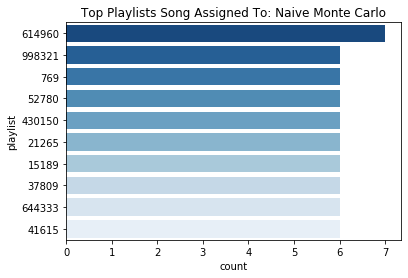

In [409]:
# Generate top 10 playlists
top_playlists_naive = select_top_n_playlists_naive(playlist_gaga, n=10000)

# Plot em
plot_top_n_playlists(top_playlists_naive, sim_type="Naive")

Next, we will weigh the playlists by inverse distance

In [410]:
def select_top_n_playlists_by_distance(df, features, trackid="spotify:track:5P5cGNzqh6A353N3ShDK6Y", n=1000):
    # Instantiate empty dict with playlist counts and empty distance array
    playlist_counts = {playlist[0]: 0 for playlist in df["playlists"]}
    distances = []
    inverse_distances = []
    
    # Compute euclidean distance from target track for each row
    gaga_feature_vector = df.set_index("trackid").loc[trackid][features].to_numpy().reshape(1,-1)
    
    for idx in range(df.shape[0]):
        target_feature_vector = df.iloc[idx][features].to_numpy().reshape(1,-1)
        distances.append(distance.euclidean(gaga_feature_vector, target_feature_vector))
        inverse_distances.append(1 / (1 + distance.euclidean(gaga_feature_vector, target_feature_vector)))
        
    # Now, get probabilities to sum to 1
    inverse_distances /= sum(inverse_distances)
        
    # Add distances as column to original df
    df["distance"] = distances    
    df["inverse_distance"] = inverse_distances
    
    # For each iteration in our specified n, count the selected playlist, this time using inverse distance
    for i in range(n):
        indices = np.arange(df.shape[0])
        idx = np.random.choice(indices, p=inverse_distances)
        playlist_counts[df.iloc[idx]["playlists"][0]] += 1
    
    # Sort by count
    # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    playlist_counts = {str(k): v for k, v in sorted(playlist_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

    return playlist_counts

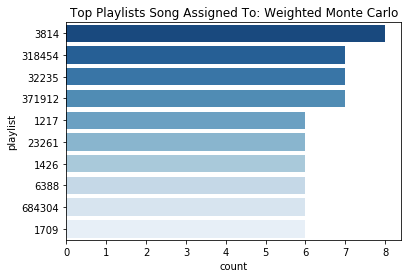

In [364]:
features = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
            "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Generate top n playlists
top_playlists_weighted = select_top_n_playlists_by_distance(playlist_gaga, features, n=10000)

# Plot em
plot_top_n_playlists(top_playlists_weighted, sim_type="Weighted")

In [411]:
# Okay, strip out these annoying lists of playlists
playlist_gaga_working = playlist_gaga.copy()
playlist_gaga_working["playlists"] = playlist_gaga_working["playlists"].apply(lambda x: x[0])

playlist_gaga_working["playlists"]

0       305773
1       194953
2       229939
3       548349
4       478734
         ...  
9916      4254
9917    501880
9918    127185
9919    374524
9920    363386
Name: playlists, Length: 9921, dtype: int64

In [412]:
# Create features df with mean values
playlist_features = playlist_gaga_working.groupby("playlists").agg({"danceability": "mean", 
                                                            "energy": "mean",
                                                            "key": "mean", 
                                                            "loudness": "mean", 
                                                            "mode": "mean", 
                                                            "speechiness": "mean",
                                                            "acousticness": "mean", 
                                                            "instrumentalness": "mean",
                                                            "liveness":"mean", 
                                                            "valence": "mean", 
                                                            "tempo": "mean", 
                                                            "duration_ms": "mean", 
                                                            "time_signature": "mean"})

playlist_features.head()
    

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
playlists,,,,,,,,,,,,,
33,0.502024,0.856,0.181818,0.892426,1.0,0.052905,0.186747,0.000047,0.3560,0.592,0.332593,0.045283,0.8
39,0.563765,0.737,0.272727,0.864321,1.0,0.049378,0.014257,0.000000,0.3140,0.817,0.637144,0.043005,0.8
53,0.862348,0.693,0.090909,0.846477,1.0,0.284232,0.024096,0.000000,0.1100,0.660,0.386870,0.049334,0.8
59,0.709514,0.864,0.272727,0.886611,1.0,0.065456,0.003323,0.000000,0.0421,0.811,0.427453,0.041896,0.8
64,0.421053,0.803,0.181818,0.876541,1.0,0.097303,0.000152,0.000270,0.2030,0.645,0.804535,0.031527,0.8


In [432]:
# Get top playlists for each
top_playlist_naive = int(max(top_playlists_naive, key=top_playlists_naive.get))
top_playlist_weighted = int(max(top_playlists_weighted, key=top_playlists_weighted.get))

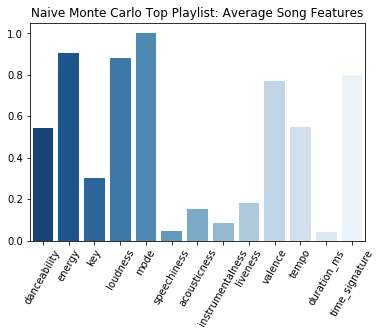

In [447]:
# Plot
naive = sns.barplot(data=playlist_features[playlist_features.index == top_playlist_naive], palette="Blues_r")
naive.set_title("Naive Monte Carlo Top Playlist: Average Song Features")

for item in naive.get_xticklabels():
    item.set_rotation(60)
    
plt.savefig(f"../out/top_playlist_song_features_naive.svg", dpi=1200)    

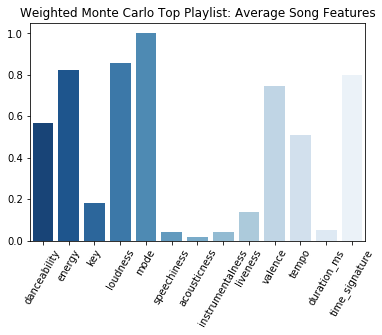

In [446]:
# Plot
weighted = sns.barplot(data=playlist_features[playlist_features.index == top_playlist_weighted], palette="Blues_r")
weighted.set_title("Weighted Monte Carlo Top Playlist: Average Song Features")

for lab in weighted.get_xticklabels():
    lab.set_rotation(60)
    
plt.savefig(f"../out/top_playlist_song_features_weighted.svg", dpi=1200)    

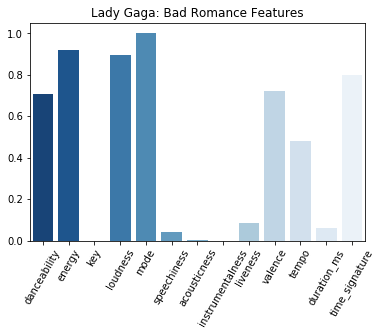

In [443]:
gaga = sns.barplot(data=playlist_gaga[playlist_gaga["trackid"] == "spotify:track:5P5cGNzqh6A353N3ShDK6Y"][features],
                  palette="Blues_r")
gaga.set_title("Lady Gaga: Bad Romance Features")

for item in gaga.get_xticklabels():
    item.set_rotation(60)



### 3. Simplest model - KNN for each playlist using musical features 

Get dataset - 250 playlists at random and all songs associated with those playlists

In [42]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\config\credentials.json"
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext google.cloud.bigquery

1. Get all tracks from random list of 250 playlists. The limiting dimension is the playlist.
2. Train test split the data (stratified on playlist id to ensure balanced data)

In [47]:
%%bigquery playlist_tracks
SELECT
    ps.unique_pid, 
    ps.artist_name, 
    ps.track_name, 
    ps.album_name, 
    th.trackid,
    th.danceability,
    th.energy,
    th.key,
    th.loudness,
    th.mode,
    th.speechiness,
    th.acousticness,
    th.instrumentalness,
    th.liveness,
    th.valence,
    th.tempo,
    th.duration_ms,
    th.time_signature
FROM
    (SELECT 
        unique_pid
    FROM
        (SELECT
            unique_pid
        FROM
            playlist_songs.playlists
        GROUP BY
            unique_pid)
    WHERE
    RAND() < 250/909100 ) as ps_id
    INNER JOIN
    playlist_songs.playlists as ps
    ON ps_id.unique_pid = ps.unique_pid
    INNER JOIN
    playlist_songs.tracks_headers as th
    ON th.trackid = ps.track_uri;

In [48]:
playlist_tracks.head(1)

,unique_pid,artist_name,track_name,album_name,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,182284,The Ukelele Beatles,Love Me Do,Love Me Do,spotify:track:2IVG6hYtv3HRpwxKFwbVEH,0.772,0.371,0,-8.993,1,0.037,0.857,0.0,0.136,0.582,130.19,153670,4


In [49]:
playlist_analysis = playlist_tracks[['unique_pid', 'trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

playlist_song_info = playlist_tracks[['trackid', 'artist_name', 'track_name', 'album_name']]

Pivot and one hot encode playlist ids

In [50]:
# create column of ones for data spread procedure later
playlist_analysis.loc[:, 'one'] = 1
# data spread procedure - group by track and features one hot encode playlist assignments
playlist_analysis = playlist_analysis.drop_duplicates(subset=['unique_pid', 'trackid'])

#create train and test (stratified by playlist)
train, test = train_test_split(playlist_analysis, train_size=0.8, stratify=playlist_analysis.unique_pid)

In [51]:
playlist_train_one_hot = train.pivot(index="trackid", columns='unique_pid', values="one")
playlist_train_one_hot = playlist_train_one_hot.fillna(value=0)

In [52]:
playlist_test_one_hot = test.pivot(index="trackid", columns='unique_pid', values="one")
playlist_test_one_hot = playlist_test_one_hot.fillna(value=0)

In [53]:
# get # playlists for each song
playlist_train_one_hot.loc[:, "sum"] = playlist_train_one_hot.sum(axis = 1)

In [54]:
playlist_train_one_hot.head()

unique_pid,3905,6635,7300,9868,10648,10803,14021,14519,19895,20173,...,978925,979294,980143,980169,985433,985939,990917,991654,995758,sum
trackid,,,,,,,,,,,,,,,,,,,,,
spotify:track:000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
spotify:track:006TSJsRLUQHpLU2aY99RN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:007iY6FDvlAwN1DVlNo8rY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
spotify:track:00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:00BzdcKHNGAbGyFtdZP1Jc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
playlist_distribution = playlist_train_one_hot.groupby("sum")["sum"].count()

Check distribution of songs that have one or more playlists

In [56]:
playlist_distribution

sum
1.0     9273
2.0     1282
3.0      474
4.0      220
5.0      115
6.0       76
7.0       37
8.0       17
9.0       13
10.0       9
11.0       3
13.0       2
16.0       1
Name: sum, dtype: int64

In [57]:
# get all playlist numbers
playlist_numbers = [i for i in playlist_train_one_hot.columns if i not in ['trackid', 'sum']]
# merge features with one-hot list
playlist_features = playlist_analysis[['trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
playlist_train_one_hot = playlist_train_one_hot.drop("sum", axis = 1)

In [58]:
playlist_train_one_hot_w_features = playlist_train_one_hot.merge(playlist_features, on="trackid", how="inner")
playlist_test_one_hot_w_features = playlist_test_one_hot.merge(playlist_features, on="trackid", how="inner")

split into X and y for training and testing

In [59]:
y_train = playlist_train_one_hot_w_features[playlist_numbers]
y_test = playlist_test_one_hot_w_features[playlist_numbers]
X_train = playlist_train_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
X_test = playlist_test_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

print(X_train.shape)
print(y_train.shape)
X_test = X_test.fillna(-1) #if na then fill with -1
X_train = X_train.fillna(-1) #if na then fill with -1

(17504, 13)
(17504, 271)


In [60]:
# convert to np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Now train and fit the model using k-nearest neighbors euclidean distance for multiple playlists

In [82]:
ks = [2, 5, 7, 10]
output = []
playlists = range(0, len(playlist_numbers))

total_loops = len(playlists) * len(ks)
with tqdm_notebook(total=total_loops) as pbar:
    for playlist in playlists:
        for k in ks:
            knn_cv = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
            # downsample the non-examples in the training
            y_examples = y_train[y_train[:, playlist]==1,]
            X_examples = X_train[y_train[:, playlist]==1,]
            number_examples = y_examples.shape[0]
            non_examples_id = np.random.choice(np.array(range(0, y_train[y_train[:, playlist]==0,].shape[0])), number_examples)
            y_non_examples = y_train[non_examples_id,]
            X_non_examples = X_train[non_examples_id,]
            X_train_sampled = np.vstack([X_examples, X_non_examples])
            y_train_sampled = np.vstack([y_examples, y_non_examples])
            
            #fit the model
            fit = knn_cv.fit(X_train_sampled, y_train_sampled[:, playlist])
            try:
                # if the prediction fails because there are not enough neighbors, then go to the next loop
                y_train_pred = fit.predict(X_train_sampled)
                y_test_pred = fit.predict(X_test)
                train_accuracy = accuracy_score(y_train_sampled[:, playlist], y_train_pred)
                train_f1 = f1_score(y_train_sampled[:, playlist], y_train_pred)
                test_accuracy = accuracy_score(y_test[:, playlist], y_test_pred)
                test_f1 = f1_score(y_test[:, playlist], y_test_pred)
                output.append({"k": k, "train_accuracy_mean": np.mean(train_accuracy),\
                               "train_f1_mean": np.mean(train_f1),\
                               "playlist": playlist,\
                               "test_accuracy_mean": np.mean(test_accuracy),\
                                "test_f1_mean": np.mean(test_f1)})
            except:
                continue
            pbar.update(1)



Plot accuracies and f1 for all playlist models at various k's

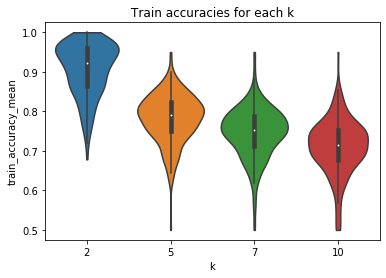

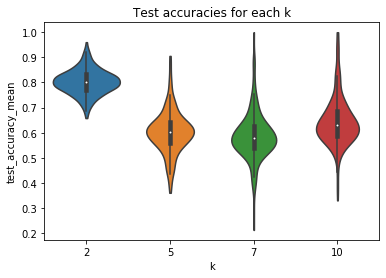

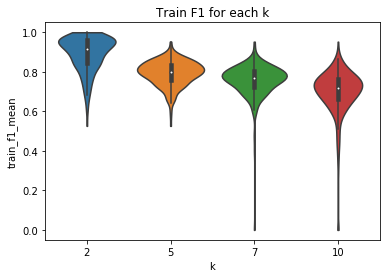

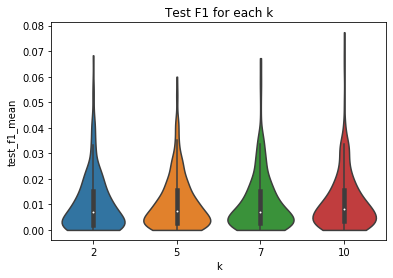

plot of mean cv scores for k=2 for multiple play lists


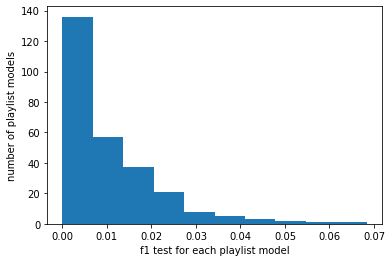

plot of mean cv scores for k=5 for multiple play lists


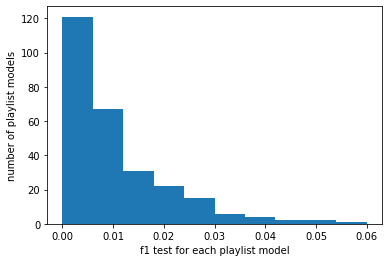

plot of mean cv scores for k=7 for multiple play lists


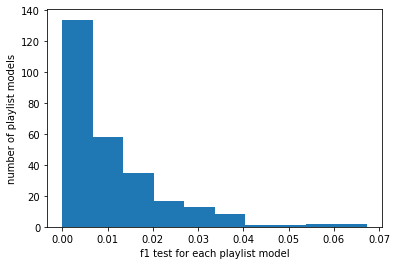

plot of mean cv scores for k=10 for multiple play lists


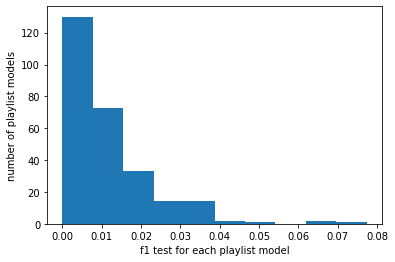

In [83]:
output = pd.DataFrame(output)

sns.violinplot(x=output.k,y=output.train_accuracy_mean, cut=0)
plt.title("Train accuracies for each k")
plt.savefig("train_accuracy.svg", dpi=1200)
plt.show()

sns.violinplot(x=output.k,y=output.test_accuracy_mean, cut=0)
plt.title("Test accuracies for each k")
plt.savefig("test_accuracy.svg", dpi=1200)
plt.show()

sns.violinplot(x=output.k,y=output.train_f1_mean, cut=0)
plt.title("Train F1 for each k")
plt.savefig("train_f1.svg", dpi=1200)
plt.show()

sns.violinplot(x=output.k,y=output.test_f1_mean, cut=0)
plt.title("Test F1 for each k")
plt.savefig("test_f1.svg", dpi=1200)
plt.show()

for k in ks:
    print(f"plot of mean cv scores for k={k} for multiple play lists")
    subset = output.loc[output.k==k,:]
    plt.hist(subset["test_f1_mean"])
    plt.xlabel("f1 test for each playlist model")
    plt.ylabel("number of playlist models")
    plt.show()
    



### 4. Structural model - Logistic regression for each playlist using musical features

In [124]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Imports for logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import os
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext google.cloud.bigquery

In [3]:
%%bigquery
SELECT
    COUNT(DISTINCT(unique_pid))
FROM
    playlist_songs.playlists;


,f0_
0,909100


In [4]:
%%bigquery
SELECT
    COUNT(unique_pid)
FROM
    playlist_songs.playlists;

,f0_
0,66346428


1. Get all tracks from random list of 1000 playlists. The limiting dimension is the playlist.
2. Train test split the data

In [77]:
%%bigquery playlist_tracks
SELECT
    ps.unique_pid, 
    ps.artist_name, 
    ps.track_name, 
    ps.album_name, 
    th.trackid,
    th.danceability,
    th.energy,
    th.key,
    th.loudness,
    th.mode,
    th.speechiness,
    th.acousticness,
    th.instrumentalness,
    th.liveness,
    th.valence,
    th.tempo,
    th.duration_ms,
    th.time_signature
FROM
    (SELECT 
        unique_pid
    FROM
        (SELECT
            unique_pid
        FROM
            playlist_songs.playlists
        GROUP BY
            unique_pid)
    WHERE
    RAND() < 500/909100 ) as ps_id
    INNER JOIN
    playlist_songs.playlists as ps
    ON ps_id.unique_pid = ps.unique_pid
    INNER JOIN
    playlist_songs.tracks_headers as th
    ON th.trackid = ps.track_uri;

In [102]:
playlist_tracks.head(1)

,unique_pid,artist_name,track_name,album_name,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,92959,Survivor,Eye of the Tiger,Eye Of The Tiger,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,0.815,0.438,0,-14.522,0,0.0346,0.216,0.000466,0.0787,0.552,108.965,243773,4


In [103]:
playlist_analysis = playlist_tracks[['unique_pid', 'trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

playlist_song_info = playlist_tracks[['trackid', 'artist_name', 'track_name', 'album_name']]

In [104]:
# create column of ones for data spread procedure later
playlist_analysis.loc[:, 'one'] = 1
# data spread procedure - group by track and features one hot encode playlist assignments
playlist_analysis = playlist_analysis.drop_duplicates(subset=['unique_pid', 'trackid'])

#create train and test (stratified by playlist)
train, test = train_test_split(playlist_analysis, train_size=0.8, stratify=playlist_analysis.unique_pid)

In [105]:
playlist_train_one_hot = train.pivot(index="trackid", columns='unique_pid', values="one")
playlist_train_one_hot = playlist_train_one_hot.fillna(value=0)

In [106]:
playlist_test_one_hot = test.pivot(index="trackid", columns='unique_pid', values="one")
playlist_test_one_hot = playlist_test_one_hot.fillna(value=0)

In [107]:
# get histogram of songs associated with # playlists
playlist_train_one_hot.loc[:, "sum"] = playlist_train_one_hot.sum(axis = 1)

In [108]:
playlist_train_one_hot.head()

unique_pid,222,373,4127,4181,5220,6212,7909,10953,11499,12857,...,984648,986338,988530,988958,990368,994789,995522,995870,999112,sum
trackid,,,,,,,,,,,,,,,,,,,,,
spotify:track:000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:004z7UbwGrprGG1JTmNgCt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:005GaX6hvgeTFnR9FvejTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:007Cm8jbhOP7ofnHEwSr6s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:00AvOVhsUi1gOCnHxTFw7i,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [109]:
playlist_distribution = playlist_train_one_hot.groupby("sum")["sum"].count()

In [110]:
playlist_distribution

sum
1.0     14900
2.0      2207
3.0       792
4.0       465
5.0       266
6.0       177
7.0       106
8.0        72
9.0        71
10.0       42
11.0       33
12.0       16
13.0       17
14.0       11
15.0       16
16.0        6
17.0        2
18.0        3
19.0        2
21.0        1
25.0        1
28.0        1
Name: sum, dtype: int64

In [111]:
# get all playlist numbers
playlist_numbers = [i for i in playlist_train_one_hot.columns if i not in ['trackid', 'sum']]
# merge features with one-hot list
playlist_features = playlist_analysis[['trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
playlist_train_one_hot = playlist_train_one_hot.drop("sum", axis = 1)

In [112]:
playlist_train_one_hot_w_features = playlist_train_one_hot.merge(playlist_features, on="trackid", how="inner")
playlist_test_one_hot_w_features = playlist_test_one_hot.merge(playlist_features, on="trackid", how="inner")

In [113]:
y_train = playlist_train_one_hot_w_features[playlist_numbers]
y_test = playlist_test_one_hot_w_features[playlist_numbers]

X_train = playlist_train_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

X_test = playlist_test_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

X_test = X_test.fillna(-1) #if na then fill with -1
X_train = X_train.fillna(-1) #if na then fill with -1

(33492, 13)
(33492, 506)


In [114]:
# convert to np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [115]:
#create mask for smaller X_train data
mask = np.random.choice([False, True], len(X_train), p=[0.75, 0.25])
X_train_compressed = X_train[mask][:]
X_train_compressed.shape
y_train_compressed = y_train[mask][:]
y_train_compressed.shape

(8362, 506)

In [116]:
# Ultimately, while we did not use normalization on predictors, because this 
# significantly slowed down the logistic regression to a process that would have 
# taken 20 hours to run; this was unfeasible.

def normalize_predictors(x_df, y_df, scaler):
    """
    Standardizes the predictors to vary between 0 and 1 to account for differences
    in scale and variability.
    
    The scaler passed in should be from the standardized data set only.
    
    Returns new x dataframe, along with y, whose index has been re-set to match
    the x df since it was run through a standardizer. 
    """
    cols_to_scale = x_df.columns
    scaled_df = scaler.fit_transform(x_df)
    
    normalized_x = pd.DataFrame(scaled_df, columns=cols_to_scale)
    normalized_x.reset_index(drop=True, inplace=True)

    # Also reset the Y-train index so that it matches the indices produced by normalization
    y_df.reset_index(drop=True, inplace=True)

    return (normalized_x, y_df)

In [149]:
playlist_indices = range(0, len(playlist_numbers))
X_COLUMNS = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']

# Normalize the data and get it into dataframe formatting so I can see what I'm working with
X_train_df = pd.DataFrame(X_train, columns=X_COLUMNS)
X_test_df = pd.DataFrame(X_test, columns=X_COLUMNS)

y_train_df = pd.DataFrame(y_train, columns=playlist_indices)
y_test_df = pd.DataFrame(y_test, columns=playlist_indices)
print(X_test_df.shape)

scaler = MinMaxScaler().fit(X_train_df)
X_train_df, y_train_df = normalize_predictors(X_train_df, y_train_df, scaler)

display(X_train_df.head())

# Now, we must also normalize our test values, using the scalar from the X_train
X_test_df, y_test_df = normalize_predictors(X_test_df, y_test_df, scaler)
display(X_test_df.head())

(15919, 13)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.757085,0.627,0.636364,0.883539,1.0,0.067435,0.131526,0.000000,0.085456,0.5240,0.550039,0.038533,0.8
1,0.757085,0.627,0.636364,0.883539,1.0,0.067435,0.131526,0.000000,0.085456,0.5240,0.550039,0.038533,0.8
2,0.649798,0.247,0.272727,0.715167,0.0,0.059372,0.996988,0.934000,0.148445,0.0908,0.345562,0.046433,0.8
3,0.791498,0.341,0.272727,0.857068,1.0,0.032565,0.278112,0.000111,0.109328,0.7090,0.441276,0.047297,0.8
4,0.491903,0.738,0.363636,0.897111,1.0,0.033822,0.013755,0.000000,0.089067,0.5850,0.814171,0.047225,0.8


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.764826,0.627693,0.636364,0.842884,1.0,0.074108,0.131526,0.000000,0.086410,0.528226,0.550239,0.038648,0.8
1,0.764826,0.627693,0.636364,0.842884,1.0,0.074108,0.131526,0.000000,0.086410,0.528226,0.550239,0.038648,0.8
2,0.586912,0.822377,0.181818,0.874147,0.0,0.030840,0.000448,0.000002,0.193712,0.301411,0.491273,0.042626,0.8
3,0.586912,0.822377,0.181818,0.874147,0.0,0.030840,0.000448,0.000002,0.193712,0.301411,0.491273,0.042626,0.8
4,0.843558,0.833415,0.454545,0.847159,0.0,0.046375,0.005894,0.000796,0.115619,0.718750,0.555052,0.045432,0.8


In [216]:
# We'll store the regression model for each playlist, along with its accuracy score as tuple

def run_logistic_regression(X_train, y_train, X_test, y_test, playlists):
    
    playlist_regression_models = []
    with tqdm_notebook(total=len(playlists)) as pbar:
        for playlist_index in playlists:
            # Downsampling; because the number of 0s vastly outpowers the number of 1s 
            # (since the dataset) is 3,000 large, we must sum the total number of 1s
            # and grab a random subsample of songs that are classified as 0
            training_set = pd.concat([X_train, y_train], axis=1)

            # First, grab all items that are in a given playlist and add that to the
            # final downsampled set
            in_playlist = training_set[training_set[playlist_index] == 1]
            not_in_playlist = training_set[training_set[playlist_index] == 0].sample(len(in_playlist))
            
            downsampled = pd.concat([in_playlist, not_in_playlist])
            
            X_train_ds = downsampled[X_COLUMNS]
            y_train_ds = downsampled[playlists]
            
            # Includes regularization by default
            logistic_reg = LogisticRegression()
            logistic_reg.fit(X_train_ds, y_train_ds[playlist_index])
            
            # Now, predict
            y_train_pred = logistic_reg.predict(X_train_ds)
            y_test_pred = logistic_reg.predict(X_test)
            
            # And check for accuracy scores
            train_accuracy = accuracy_score(y_train_ds[playlist_index], y_train_pred)
            train_f1 = f1_score(y_train_ds[playlist_index], y_train_pred)
            
            test_accuracy = accuracy_score(y_test[playlist_index], y_test_pred)
            test_f1 = f1_score(y_test[playlist_index], y_test_pred)

            model_info = {
                "model": regression_l1, 
                "train_accuracy": train_accuracy, 
                "test_accuracy": test_accuracy, 
                "train_f1": train_f1,
                "test_f1": test_f1,
            }
            playlist_regression_models.append(model_info)
            pbar.update(1)

    return playlist_regression_models

lr_models = run_logistic_regression(X_train_df, y_train_df, X_test_df, y_test_df, playlist_indices)

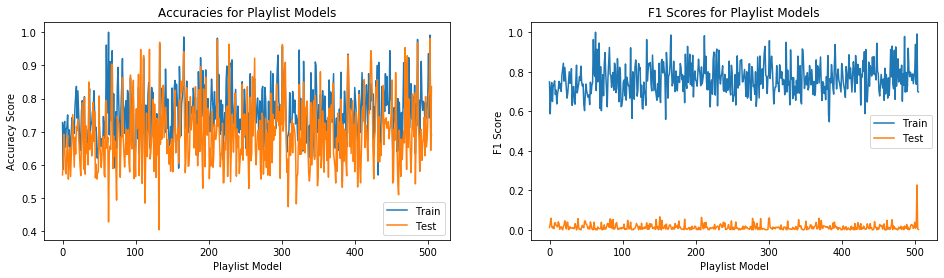

In [316]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

model_index = range(0, len(lr_models))
train_accuracies = [m["train_accuracy"] for m in lr_models]
test_accuracies = [m["test_accuracy"] for m in lr_models]
train_f1s = [m["train_f1"] for m in lr_models]
test_f1s = [m["test_f1"] for m in lr_models]

ax[0].plot(model_index, train_accuracies, label="Train")
ax[0].plot(model_index, test_accuracies, label="Test")
ax[0].set_title("Accuracies for Playlist Models")
ax[0].set_xlabel("Playlist Model")
ax[0].set_ylabel("Accuracy Score")
ax[0].legend()

ax[1].plot(model_index, train_f1s, label="Train")
ax[1].plot(model_index, test_f1s, label="Test")
ax[1].set_title("F1 Scores for Playlist Models")
ax[1].set_xlabel("Playlist Model")
ax[1].set_ylabel("F1 Score")
ax[1].legend()
plt.savefig("accuracies_playlist_models.svg", dpi=1200)

# This demonstrates the clear inability for logistic regression to classify songs as to whether or not they belong
# within a playlist

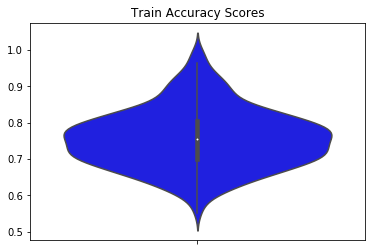

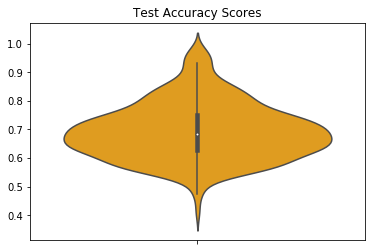

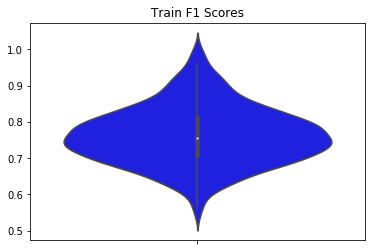

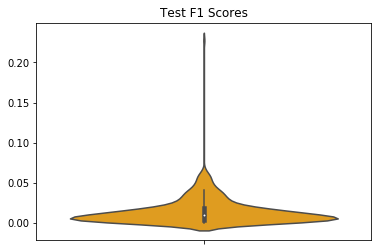

In [309]:
sns.violinplot(y=[train_accuracies], color="Blue")
plt.title("Train Accuracy Scores")
plt.savefig("train_accuracy_regression_violin.svg", dpi=1200)
plt.show()

sns.violinplot(y=[test_accuracies], color="orange")
plt.title("Test Accuracy Scores")
plt.savefig("test_accuracy_regression_violin.svg", dpi=1200)
plt.show()

sns.violinplot(y=[train_f1s], color="blue")
plt.title("Train F1 Scores")
plt.savefig("train_f1_regression_violin.svg", dpi=1200)
plt.show()

sns.violinplot(y=[test_f1s], color="orange")
plt.savefig("test_f1_regression_violin.svg", dpi=1200)
plt.title("Test F1 Scores")
plt.show()


In [281]:
import math

def predictor_t_values(X_train, y_train, playlists):
    """
    Returns top 10 t-values, indicating which items
    provide the most signal as a predictor between the
    two types.
    
    Takes in the statistics of two types as a parameter.
    """
    predictors = pd.DataFrame(columns = X_COLUMNS)    
    with tqdm_notebook(total=len(playlists)) as pbar:
        for playlist_index in playlists:
            training_set = pd.concat([X_train, y_train], axis=1)

            # First, grab all items that are in a given playlist and add that to the
            # final downsampled set
            in_playlist = training_set[training_set[playlist_index] == 1]
            not_in_playlist = training_set[training_set[playlist_index] == 0].sample(len(in_playlist))

            downsampled = pd.concat([in_playlist, not_in_playlist])

            type_1 = downsampled[downsampled[playlist] == 1]
            type_2 = downsampled[downsampled[playlist] == 0]

            signal = np.abs(type_1.mean() - type_2.mean())
            type_1_noise = (type_1.var()) / type_1.count()
            type_2_noise = (type_2.var()) / type_2.count()
            noise = np.sqrt(type_1_noise + type_2_noise)
            t_values = signal / noise
            results = t_values.sort_values(ascending=False).drop(playlists).to_dict()
            predictors = predictors.append(results, ignore_index=True)
            pbar.update(1)
    return predictors

predictor_t_values = get_top_10_tvalues(X_train_df, y_train_df, playlist_indices)


The advantage of structural models is we can figure out which features contribute the most to the predictiveness of the models. We can do this using t-tests for each model and plot trends.

In [326]:
cached_t_values = predictor_t_values.copy()
display(cached_t_values.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2.607249,2.581562,11.093327,0.541466,1.860042,1.492106,4.375996,6.025247,3.115747,1.587198,0.855237,0.303384,1.568965
1,2.580996,2.324564,0.865553,1.262997,2.586961,1.581846,2.314632,3.754927,4.646455,0.818707,7.012750,0.536048,1.381286
2,1.324791,2.978071,2.164183,0.965195,0.717694,2.169052,1.897335,1.310227,0.304684,0.374343,3.244123,1.630775,0.363333
3,4.693447,3.267463,0.303121,4.455151,1.225324,4.208305,4.712808,6.490080,0.331220,5.129734,1.289560,7.252466,4.587534
4,0.537312,1.613837,0.333123,0.867496,23.089886,0.179221,0.033567,5.181181,2.507461,1.099578,1.570118,0.122911,3.385955


In [327]:
without_nan = predictor_t_values.dropna()

In [329]:
top_predictors_average = pd.DataFrame(without_nan.mean(), columns=["mean_t_value"]).sort_values(by="mean_t_value", ascending=False)
display(top_predictors_average)

,mean_t_value
mode,4.830486
speechiness,4.624056
instrumentalness,4.049592
tempo,4.003240
liveness,3.322635
acousticness,3.285192
key,2.908370
energy,2.907320
loudness,2.705092
valence,2.510551


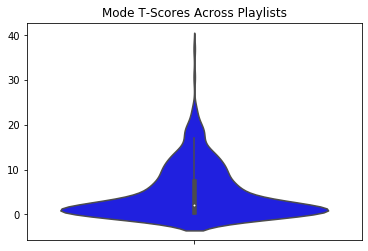

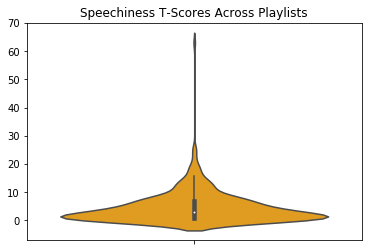

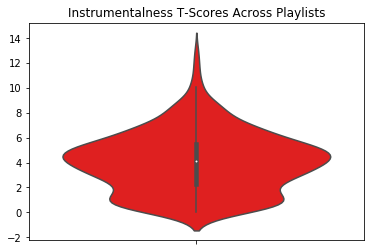

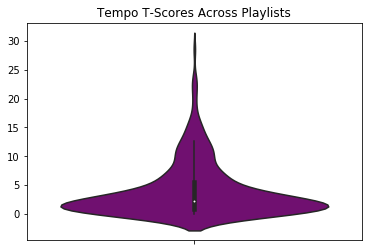

In [330]:
sns.violinplot(y=[predictor_t_values["mode"]], color="Blue")
plt.title("Mode T-Scores Across Playlists")
plt.savefig("mode_t_score.svg", dpi=1200)
plt.show()

sns.violinplot(y=[predictor_t_values["speechiness"]], color="Orange")
plt.title("Speechiness T-Scores Across Playlists")
plt.savefig("speechiness_t_score.svg", dpi=1200)
plt.show()

sns.violinplot(y=[predictor_t_values["instrumentalness"]], color="Red")
plt.title("Instrumentalness T-Scores Across Playlists")
plt.savefig("Instrumentalness_t_score.svg", dpi=1200)
plt.show()

sns.violinplot(y=[predictor_t_values["tempo"]], color="Purple")
plt.title("Tempo T-Scores Across Playlists")
plt.savefig("Tempo_t_score.svg", dpi=1200)
plt.show()